In [49]:
from __future__ import division
from collections import defaultdict
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)
import re
from time import time
from bs4 import BeautifulSoup
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
import numpy as np
np.seterr(all='raise')
np.random.seed(1337)
from nltk.corpus import stopwords
import nltk.data
import pandas as pd
from scipy.stats import poisson, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import load_digits

In [50]:
alpha = 6
sigma_x = sigma = 5
sigma_a = 5

In [51]:
def log_X_given_Z(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I1 = np.identity(K)
    I2 = np.identity(N)
    
    rep_term = Z.T @ Z + (sigma ** 2 / sigma_a ** 2) * I1
    # get log of numerator and denominator, and return log prob
    num = (-1/(2*(sigma**2))) * np.trace(X.T @ (I2 - Z @ np.linalg.inv(rep_term) @ Z.T) @ X)
    denom = (np.log(2 * np.pi) * (N * D / 2)) + (np.log(sigma) * ((N - K) * D)) + (np.log(sigma_a) * (K * D)) + \
            (np.log(np.linalg.det(rep_term)) * (D / 2))
          
    return (num - denom)

def log_X_given_Z_A(X, Z, A):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]

    # return log prob
    return -np.log(2*np.pi*sigma**2) * (N * D / 2) - (1/(2*sigma**2)) * np.trace((X - Z @ A).T @ (X - Z @ A))

def resample(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I = np.identity(K)
    
    rep_term = np.linalg.inv(Z.T @ Z + ((sigma/sigma_a)**2) * I)
    means = rep_term @ Z.T @ X
    cov = (sigma**2) * rep_term
                 
    return np.array([np.random.multivariate_normal(mean, cov) for mean in means.T]).T

def make_additional_columns(N, row, num_cols):
    add_cols = np.zeros((N, num_cols))
    add_cols[row] = 1
    return add_cols

def generate_sample(Z_row, dim):
    '''
    Generate random output sample given feature matrix. 
    '''
    K = len(Z_row)
    samples = []
    probs = []
    for _ in range(1000):
        sample = np.random.uniform(size = dim)
        prob = log_X_given_Z(sample.reshape(1, dim), Z_row.reshape(1, K))
        samples.append(sample)
        probs.append(prob)   
    samples = np.asarray(samples)
    probs = np.asarray(probs)
    # normalize probabilities
    probs -= np.max(probs)
    probs = np.exp(probs)
    probs /= np.sum(probs)
    sample_index = np.random.choice(np.arange(len(probs)), p = probs)
    generated_sample = samples[sample_index]
    
    return generated_sample

def sample_row(X, Z, row):
    '''
    Sample each row using collapsed Gibbs sampler. 
    '''
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    truncation = D // 2
    Z_new = np.copy(Z)
    
    # sample existing features
    for i in range(K):
        col_sum = Z[:, i].sum()
        Z_new[row, i] = 0
        log_prob_0 = log_X_given_Z(X, Z_new) 
        Z_new[row, i] = 1
        log_prob_1 = log_X_given_Z(X, Z_new) 
        M = max(log_prob_0, log_prob_1)
        prob = (((N - col_sum) / N) * np.exp(log_prob_0 - M)) / (((N - col_sum) / N) * np.exp(log_prob_0 - M) + \
                                                           (col_sum / N) * np.exp(log_prob_1 - M))
        sampled_entry = np.random.choice([0, 1], p = [prob, 1 - prob])
        #if Z_new[row, i] != sampled_entry:
        #    print("ENTRY CHANGED")
        Z_new[row, i] = sampled_entry
        
    # sample new features for Z and A
    probs = []
    for i in range(truncation + 1):
        Z1 = np.concatenate((Z_new, make_additional_columns(N, row, i)), axis = 1)
        probs.append(log_X_given_Z(X, Z1))
        
    # prior probabilities
    prior_probs = np.copy(probs)
    prior_probs = prior_probs - np.max(prior_probs)
    prior_probs = np.exp(prior_probs)
    
    probs = np.array(probs) - np.max(probs)
    probs = np.exp(probs)
    probs = probs * np.array([poisson.pmf(i, alpha / N) for i in range(truncation + 1)])
    probs /= np.sum(probs)
    new_features = np.random.choice(np.arange(truncation + 1), p = probs)
    Z_new = np.concatenate((Z_new, make_additional_columns(N, row, new_features)), axis = 1)
    
    return Z_new, prior_probs, probs

In [52]:
cutoff = 10

def add_col_to_Z(Z, n, q):
    newWidth = Z.shape[1] + q
    newZ = np.zeros((Z.shape[0], newWidth))
    newZ[:,:Z.shape[1]] = Z
    newZ[n,Z.shape[1]:] = np.ones(q)
    return newZ

def remove_empty_col(Z):
    newZ = np.copy(Z)
    empty = []
    for k in range(Z.shape[1]):
        if sum(Z[:,k]) == 0:
            empty.append(k)
    newZ = np.delete(newZ, empty, 1)
    return newZ
    
def collapsed_log_X_given_Z(Z):
    I = np.identity(Z.shape[1])
    I2 = np.identity(Z.shape[0])
    N, K = Z.shape
    H1 = np.dot(Z.T, Z) + (sigma_x / sigma_a) ** 2 * I
    H2 = np.dot(np.dot(Z, np.linalg.inv(H1)), Z.T)
    numer = -1. / (2 * sigma_x ** 2) * np.trace(np.dot(np.dot(X.T, I2 - H2), X))
    denom = (N * D / 2) * np.log(2 * np.pi) + ((N - K) * D) * np.log(sigma_x) + (D * K) * np.log(sigma_a) + (D/2) * np.log(np.linalg.det(H1))
    return numer - denom
    
def collapsed_existing_log_prob(Z, n, k, value=1):
    N, K = Z.shape
    Z[n][k] = value
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    return p + collapsed_log_X_given_Z(Z)

def collapsed_get_newk(inZ, n):
    lp = []
    
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N, K = Z.shape
        log_prob = np.log(poisson.pmf(q, alpha/N)) + collapsed_log_X_given_Z(Z)
        #print log_prob
        lp.append(log_prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)
    

def collapsed_update_row(inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N, K = Z1.shape
    for k in range(K):
        lp1 = collapsed_existing_log_prob(Z1,n,k,1)
        lp2 = collapsed_existing_log_prob(Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = collapsed_get_newk(Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    return newZ

In [53]:
def add_col_to_Z(Z, n, q):
    newWidth = Z.shape[1] + q
    newZ = np.zeros((Z.shape[0], newWidth))
    newZ[:,:Z.shape[1]] = Z
    newZ[n,Z.shape[1]:] = np.ones(q)
    return newZ

def remove_empty_col(Z):
    newZ = np.copy(Z)
    empty = []
    for k in range(Z.shape[1]):
        if sum(Z[:,k]) == 0:
            empty.append(k)
    newZ = np.delete(newZ, empty, 1)
    return newZ



cutoff = 5


def sample_A(X, Z):
    D = X.shape[1]
    newA = np.zeros((Z.shape[1], D))
    I = np.identity(Z.shape[1])
    mean = np.dot(np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I), np.dot(Z.T, X))
    cov = sigma ** 2 * np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I)
    for d in range(D):
        newA[:,d] = np.random.multivariate_normal(mean[:,d], cov)
    
    return newA

def uncollapsed_log_X_given_ZA(X, Z,A):
    N,K = Z.shape
    D = X.shape[1]
    I = np.identity(K)
    H1 = X - np.dot(Z,A)
    numer = -1. / (2 * sigma ** 2) * np.trace(np.dot(H1.T, H1))
    denom = (N * D / 2) * np.log(2 * np.pi * sigma **2) 
    return numer - denom

def uncollapsed_existing_log_prob(X,Z,n,k,value=1):
    Z[n][k] = value
    A = sample_A(X,Z)
    N,K = Z.shape
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    
    return p + uncollapsed_log_X_given_ZA(X,Z,A)

def uncollapsed_get_newk(X,inZ, n):
    lp = []
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N,K = Z.shape
        A = sample_A(X,Z)
        prob = np.log(poisson.pmf(q, alpha/N)) + uncollapsed_log_X_given_ZA(X,Z, A)
        lp.append(prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)

def uncollapsed_update_row(X,inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N,K = Z1.shape
    for k in range(K):
        lp1 = uncollapsed_existing_log_prob(X,Z1,n,k,1)
        lp2 = uncollapsed_existing_log_prob(X,Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = uncollapsed_get_newk(X,Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    newZ = remove_empty_col(newZ)
    return newZ, 0, 0

## MNIST Dataset

In [60]:
digits = load_digits().data # digits are 8x8, pick first 100 for now
target = load_digits().target # correct value of each digit
D = digits.shape[0]
for i in range(digits.shape[0]):
    digits[i] = digits[i] / digits[i].max()
im_dim = 8
dist_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        row1 = i // 8
        col1 = i % 8
        row2 = j // 8
        col2 = j % 8
        dist_matrix[i][j] = np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)
        
def select_digit_subset(digits, target, digits_per_class = 20):
    classes = defaultdict(list)
    for index, digit in enumerate(digits):
        classes[target[index]].append(digit)
    subset = []
    for key in classes:
        digit_class = np.array(classes[key])
        subset += list(digit_class[np.random.choice(np.arange(len(digit_class)), size = digits_per_class)])
    
    return np.array(subset)

def wasserstein(p_, q_, cost_matrix = dist_matrix, epsilon = 0.05 * np.median(dist_matrix), niterations = 100):
    # in case p_ or q_ contain 0's
    p = p_ + 1e-15
    q = q_ + 1e-15
    N = len(p)
    M = len(q)
    K = np.exp((-1 / epsilon) * cost_matrix)
    K_transpose = K.transpose()
    K_tilde = np.diag(1 / p) @ K
    u = np.repeat(1. / N, N)
    for _ in range(niterations):
        u = 1 / (K_tilde @ (q / (K_transpose @ u + 1e-15)) + 1e-15)
    v = q / (K_transpose @ u + 1e-15)
    transportmatrix = np.diag(u) @ K @ np.diag(v)
    uXIv = u * ((K * cost_matrix) @ v)
    d = uXIv.sum()
    return abs(d), transportmatrix, u, v

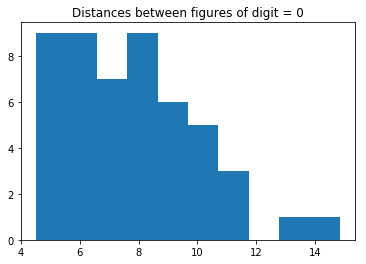

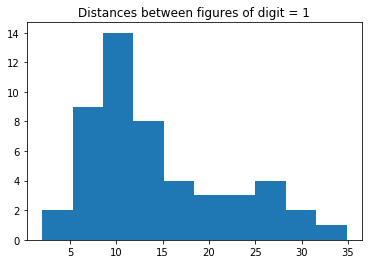

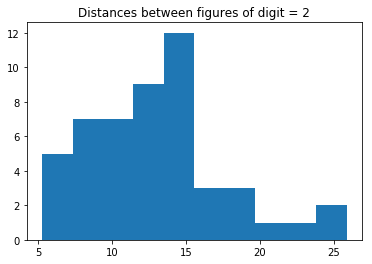

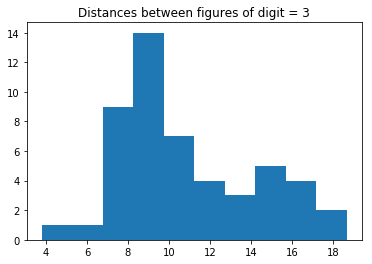

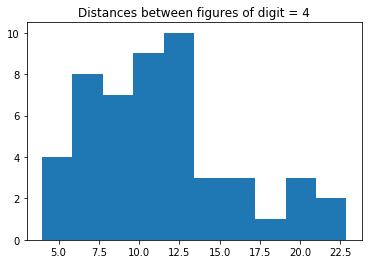

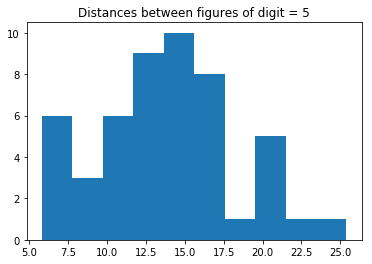

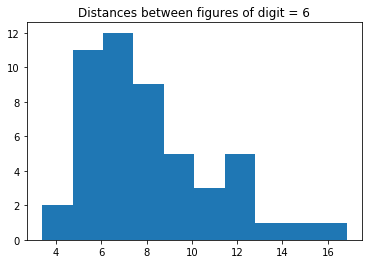

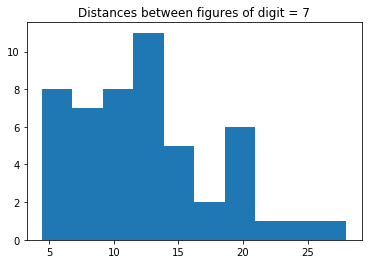

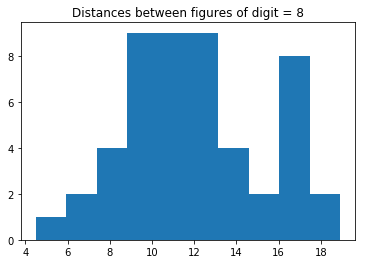

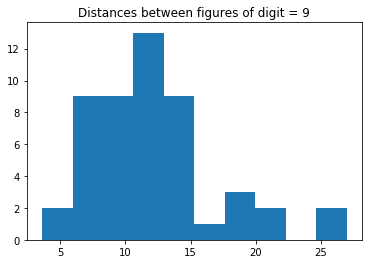

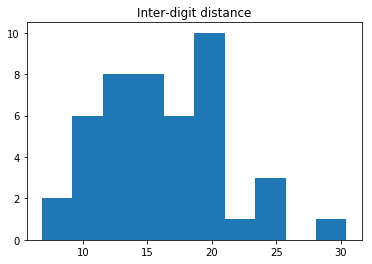

In [12]:
# get statistics about wasserstein distance between images in each category, and in different categories
digits = load_digits().data # digits are 8x8
target = load_digits().target # labels of each digit
for i in range(digits.shape[0]):
    digits[i] = digits[i] / digits[i].max()
dist_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        row1 = i // 8
        col1 = i % 8
        row2 = j // 8
        col2 = j % 8
        dist_matrix[i][j] = np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

digit_samples = defaultdict(list)
for index, digit in enumerate(target):
    digit_samples[digit].append(digits[index]) 
digit_samples = {key : np.array(val) for key, val in digit_samples.items()}
    
for digit in range(10):
    # sample 20 digits from each digit class
    samples = digit_samples[digit]
    indices = set()
    while len(indices) < 50:
        index1 = np.random.randint(len(samples))
        index2 = np.random.randint(len(samples))
        if index1 != index2:
            indices.add((index1, index2))
    all_dist = []
    for index1, index2 in indices:
        dist, _, _, _ = wasserstein(samples[index1], samples[index2])
        all_dist.append(dist)
    fig, ax = plt.subplots()
    ax.set_title("Distances between figures of digit = {}".format(digit))
    _, bins, _ = ax.hist(all_dist)

all_dist = []
for digit1 in range(10):
    for digit2 in range(digit1):
        dist, _, _, _ = wasserstein(digit_samples[digit1][0], digit_samples[digit2][0])
        all_dist.append(dist)
fig, ax = plt.subplots()
ax.set_title("Inter-digit distance")
_, bins, _ = ax.hist(all_dist)
plt.show()

In [13]:
# compare Gaussian distribution between images to Wasserstein distance between images, and see if Wasserstein
# distance gives a stronger signal
same_image_normal = []
diff_image_normal = []
same_image_wasser = []
diff_image_wasser = []

for digit in range(10):
    print(digit)
    # sample 20 digits from each digit class to use as centers, and 100 others to compute distance from
    samples = digit_samples[digit]
    images = samples[np.random.choice(np.arange(len(samples)), size = 20 + 100)]
    other_images = np.concatenate([digit_samples[i][np.random.choice(np.arange(len(digit_samples[i])), size = 11)]
                                   for i in range(10) if i != digit])
    same_normal, diff_normal, same_wasser, diff_wasser = 0, 0, 0, 0
    for center in images[:20]:
        pdf_same = multivariate_normal.pdf(images[20:], center, sigma_x * np.identity(len(center)))
        dist_same = np.array([wasserstein(center, im)[0] for im in images[20:]])
        pdf_diff = multivariate_normal.pdf(other_images, center, sigma_x * np.identity(len(center)))
        dist_diff = np.array([wasserstein(center, im)[0] for im in other_images])
        
        same_normal += pdf_same.mean()
        same_wasser += dist_same.mean()
        diff_normal += pdf_diff.mean()
        diff_wasser += dist_diff.mean()
        
    same_image_normal.append(same_normal / 20)
    diff_image_normal.append(diff_normal / 20)
    same_image_wasser.append(same_wasser / 20)
    diff_image_wasser.append(diff_wasser / 20)

same_image_normal, diff_image_normal, same_image_wasser, diff_image_wasser = \
np.array(same_image_normal), np.array(diff_image_normal), np.array(same_image_wasser), np.array(diff_image_wasser)

0
1
2
3


KeyboardInterrupt: 

In [ ]:
plt.title("Ratio between same class distance and different class distance")
plt.plot(range(10), diff_image_normal / same_image_normal, label = "Normal PDF")
plt.plot(range(10), diff_image_wasser / same_image_wasser, label = "Wasserstein")
plt.savefig("ratio_class_dist.png")
plt.xticks(range(10))
plt.legend()
plt.show()

In [ ]:
def Gibbs_Sampling(X, Z, epsilon = 50):
    # right now we use the collapsed Gibbs sampler
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    times = []
    likelihoods = []
    Z_new = Z.copy()
    start = time()
    for _ in range(3):
        for i in range(N):
            print(i)
            print("Sum of Z_new: {}".format(Z_new.sum()))
            Z_new, _, _ = sample_row(X, Z_new, i)
            if i % 10 == 0:
                times.append(time() - start)
                likelihoods.append(log_X_given_Z(X, Z_new))
                
    return times, likelihoods, Z_new

In [ ]:
start = time()
test_data = select_digit_subset(digits, target)
data_count = test_data.shape[0]
feature_count = 15
Z = np.random.binomial(1, 0.25, [data_count, feature_count])
times_gibbs_collapsed, likelihoods_gibbs_collapsed, Z_new = Gibbs_Sampling(test_data, Z)
print("Total Time: {}".format(time() - start))

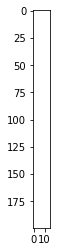

In [86]:
plt.imshow(Z_new, cmap='Greys', interpolation='none')
plt.savefig("collapsed_gibbs.png")
plt.show()

In [109]:
def change_epsilon(epsilon, alpha, fraction_accepted):
    '''
    Modify epsilon as the MCMC procedure is run, as well as alpha. Right now, we use 
    an exponential decay model, with epsilon(t) = epsilon * e^(-alpha * t).
    If the epsilon is too stringent, we binary search to find the appropriate alpha. 
    '''
    if fraction_accepted < 0.02:
        return alpha, epsilon * np.exp(alpha / 2)
    else:
        return alpha, epsilon * np.exp(-alpha)
    
def ABC_MCMC(X, Z, epsilon = 1.5, alpha = 0.01, adjust_epsilon = False):
    vis_Z = []
    epsilons = []
    # right now we use the collapsed Gibbs sampler
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    A = np.random.multivariate_normal(np.zeros(K), sigma_a * np.identity(K), size = D).T
    Z_new = Z.copy()
    start = time()
    times = []
    likelihoods = []
    wass = {}
    
    iterations = 5
    for it in range(iterations):
        print("iteration: ",it)
        for i in range(N):
            print("Shape of Z: ", Z_new.shape)
            
            
            fraction_accepted = 0
            K = Z_new.shape[1]
            
            
            old_wass, _, _, _ = wasserstein(Z_new[i] @ A, X[i])
            
            if i % 10 == 0:
                times.append(time() - start)
                likelihoods.append(uncollapsed_log_X_given_ZA(X, Z_new, A))
            print(i)
            
            if i not in wass:
                wass[i] = [old_wass]
            
            for j in range(K):
                Z_sample = Z_new.copy()
                Z_sample[i][j] = (Z_sample[i][j] + 1) % 2
                Z_row = Z_sample[i]
                #A = np.random.multivariate_normal(np.zeros(K), sigma_a * np.identity(K), size = D).T
                sample = Z_row @ A
                wasserstein_dist, _, _, _ = wasserstein(sample, X[i])
     
                if wasserstein_dist < epsilon and wasserstein_dist < old_wass * 1.2:
                    #print(wasserstein_dist)
                    Z_new = Z_sample
                    vis_Z = Z_new.copy()
                    fraction_accepted += 1
                    old_wass = wasserstein_dist
                    wass[i].append(old_wass)
                    
#             Z_new_ph = Z_new.copy()
#             for q in range(1,5):
#                 Z_sample = Z_new_ph.copy()
#                 Z_row = Z_sample[i]
#                 Z_row = np.append(Z_row, [1] * q)
#                 A = np.random.multivariate_normal(np.zeros(K+q), sigma_a * np.identity(K+q), size = D).T
#                 sample = Z_row @ A
#                 wasserstein_dist, _, _, _ = wasserstein(sample, X[i])

#                 if wasserstein_dist < epsilon and wasserstein_dist < old_wass:
#                     #print(wasserstein_dist)
#                     Z_new = add_col_to_Z(Z_new, i, 1) # add one column at a time
#                     vis_Z = Z_new.copy()
#                     old_wass = wasserstein_dist
#                     wass[i].append(old_wass)
#                 else:
#                     break
            fraction_accepted /= N
            if adjust_epsilon: 
                alpha, epsilon = change_epsilon(epsilon, alpha, fraction_accepted)
                epsilons.append(epsilon)
    if adjust_epsilon:
        return times, likelihoods, vis_Z, epsilons
    else:
        return times, likelihoods, vis_Z, wass

In [117]:
start = time()
test_data = select_digit_subset(digits, target)
data_count = test_data.shape[0]
feature_count = 30
Z = np.random.binomial(1, 0.75, [data_count, feature_count])
print(Z)
#Z = np.zeros((data_count, feature_count))

times_epsilon_fixed, likelihoods_epsilon_fixed, vis_Z, wass = ABC_MCMC(test_data, Z)
print("Total Time: {}".format(time() - start))

[[1 1 0 ..., 1 1 1]
 [1 0 0 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 0]
 [0 1 0 ..., 1 0 1]]
iteration:  0
Shape of Z:  (200, 30)
0
Shape of Z:  (200, 30)
1
Shape of Z:  (200, 30)
2
Shape of Z:  (200, 30)
3
Shape of Z:  (200, 30)
4
Shape of Z:  (200, 30)
5
Shape of Z:  (200, 30)
6
Shape of Z:  (200, 30)
7
Shape of Z:  (200, 30)
8
Shape of Z:  (200, 30)
9
Shape of Z:  (200, 30)
10
Shape of Z:  (200, 30)
11
Shape of Z:  (200, 30)
12
Shape of Z:  (200, 30)
13
Shape of Z:  (200, 30)
14
Shape of Z:  (200, 30)
15
Shape of Z:  (200, 30)
16
Shape of Z:  (200, 30)
17
Shape of Z:  (200, 30)
18
Shape of Z:  (200, 30)
19
Shape of Z:  (200, 30)
20
Shape of Z:  (200, 30)
21
Shape of Z:  (200, 30)
22
Shape of Z:  (200, 30)
23
Shape of Z:  (200, 30)
24
Shape of Z:  (200, 30)
25
Shape of Z:  (200, 30)
26
Shape of Z:  (200, 30)
27
Shape of Z:  (200, 30)
28
Shape of Z:  (200, 30)
29
Shape of Z:  (200, 30)
30
Shape of Z:  (200, 30)
31
Shape of Z:  (200, 30)
32
Shape of Z

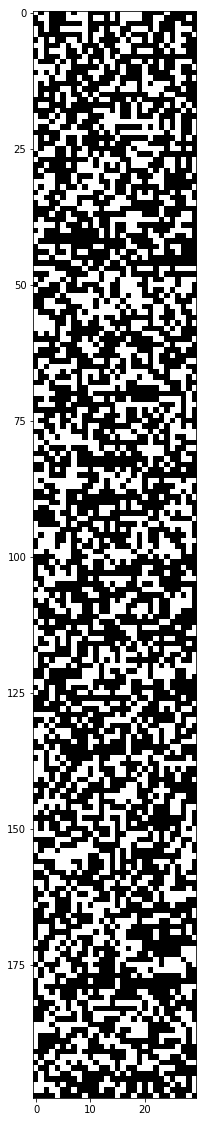

In [119]:
plt.figure(figsize = (10, 20))
plt.imshow(vis_Z, cmap='Greys', interpolation='none')
plt.savefig("epsilon_fixed.png")
plt.show()

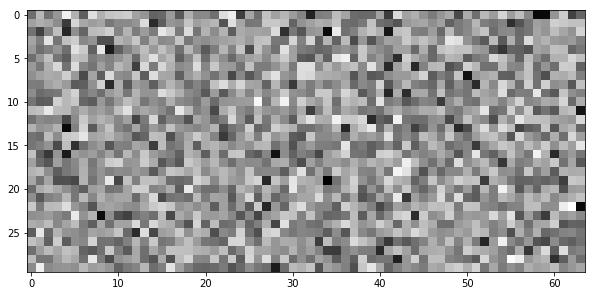

In [120]:
N = vis_Z.shape[0]
K = vis_Z.shape[1]
D = test_data.shape[1]
A = np.random.multivariate_normal(np.zeros(K), sigma_a * np.identity(K), size = D).T
plt.figure(figsize = (10, 20))
plt.imshow(A, cmap='Greys', interpolation='none')
plt.savefig("epsilon_fixed.png")
plt.show()

In [97]:
start = time()
test_data = select_digit_subset(digits, target)
data_count = test_data.shape[0]
feature_count = 15
Z = np.random.binomial(1, 0.25, [data_count, feature_count])
times_epsilon_changing, likelihoods_epsilon_changing, vis_Z, epsilons = ABC_MCMC(test_data, Z, epsilon = 0.5, adjust_epsilon = True)
print("Total Time: {}".format(time() - start))

iteration:  0
Shape of Z:  (200, 15)
0
Shape of Z:  (200, 15)
1
Shape of Z:  (200, 15)
2
Shape of Z:  (200, 15)
3
Shape of Z:  (200, 15)
4
Shape of Z:  (200, 15)
5
Shape of Z:  (200, 15)
6
Shape of Z:  (200, 15)
7
Shape of Z:  (200, 15)
8
Shape of Z:  (200, 15)
9
Shape of Z:  (200, 15)
10
Shape of Z:  (200, 15)
11
Shape of Z:  (200, 15)
12
Shape of Z:  (200, 15)
13
Shape of Z:  (200, 15)
14
Shape of Z:  (200, 15)
15
Shape of Z:  (200, 15)
16
Shape of Z:  (200, 15)
17
Shape of Z:  (200, 15)
18
Shape of Z:  (200, 15)
19
Shape of Z:  (200, 15)
20
Shape of Z:  (200, 15)
21
Shape of Z:  (200, 15)
22
Shape of Z:  (200, 15)
23
Shape of Z:  (200, 15)
24
Shape of Z:  (200, 15)
25
Shape of Z:  (200, 15)
26
Shape of Z:  (200, 15)
27
Shape of Z:  (200, 15)
28
Shape of Z:  (200, 15)
29
Shape of Z:  (200, 15)
30
Shape of Z:  (200, 15)
31
Shape of Z:  (200, 15)
32
Shape of Z:  (200, 15)
33
Shape of Z:  (200, 15)
34
Shape of Z:  (200, 15)
35
Shape of Z:  (200, 15)
36
Shape of Z:  (200, 15)
37
Shape of

KeyboardInterrupt: 

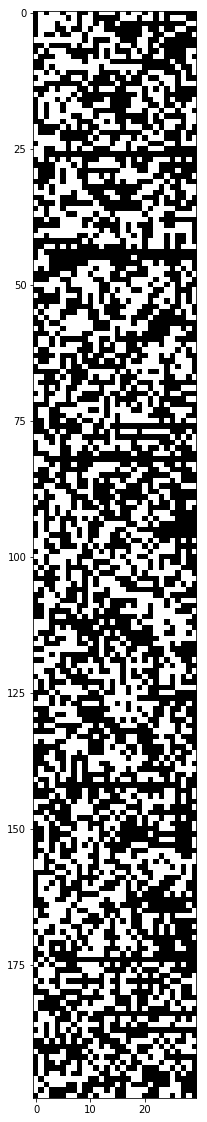

In [107]:
plt.figure(figsize = (10, 20))
plt.imshow(vis_Z, cmap='Greys', interpolation='none')
plt.savefig("epsilon_changing.png")
plt.show()

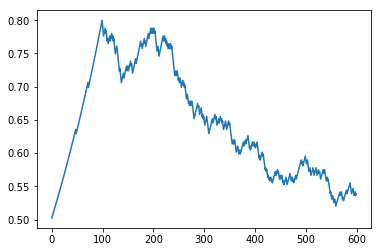

In [68]:
plt.plot(range(len(epsilons)), epsilons)
plt.show()

In [20]:
%load_ext line_profiler

In [25]:
%lprun -f ABC_MCMC ABC_MCMC(test_data, Z)

iteration:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide


21
22
23
24
25
26
27
28
29
30


/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in true_divide


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


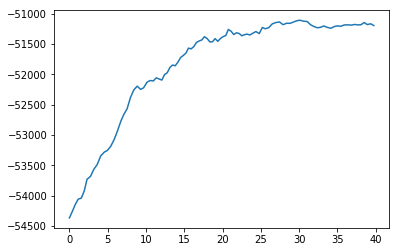

In [121]:
plt.plot(times_epsilon_fixed, likelihoods_epsilon_fixed)
plt.show()

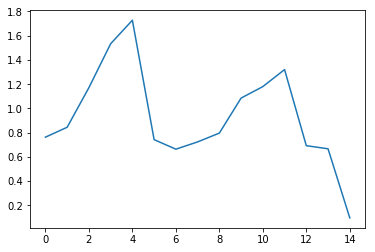

In [92]:
row = 130
plt.plot(np.arange(len(wass[row])), wass[row])
plt.show()

In [27]:
plt.plot(times_epsilon_changing, likelihoods_epsilon_changing)
plt.show()

NameError: name 'times_epsilon_changing' is not defined

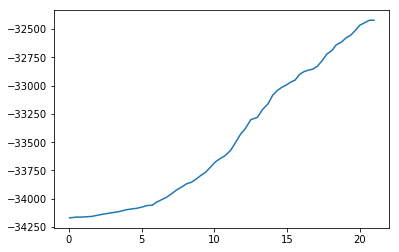

In [80]:
plt.plot(times_gibbs_collapsed, likelihoods_gibbs_collapsed)
plt.show()

## Kaggle 50000 Movie Review Analysis

In [12]:
def review_to_wordlist( review, remove_stopwords=False ):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False, doc2vec=False):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for index, raw_sentence in enumerate(raw_sentences):
        if len(raw_sentence) > 0:
            if doc2vec:
                sentence = LabeledSentence(words = review_to_wordlist(raw_sentence, remove_stopwords), 
                                           tags=['SENT_{}'.format(index)])
                sentences.append(sentence)
            else:
                sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    for word in words:
        if word in model: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       counter = counter + 1
    return reviewFeatureVecs

In [4]:
# Unlabeled training data, we will use this for testing the ABC/IBP
train = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []  # Initialize an empty list of sentence
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.archive.org/detail

In [31]:
# the parameters of the Word2Vec model
num_features = 70    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "word2vec_untrained_samples_model.pkl"
model.save(model_name)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.archive.org/detail

In [13]:
# Unlabeled training data, we will use this for testing the ABC/IBP
train = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []  # Initialize an empty list of sentence
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer, doc2vec = True)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.archive.org/detail

In [14]:
# the parameters of the Word2Vec model
num_features = 70    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = Doc2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "doc2vec_untrained_samples_model.pkl"
model.save(model_name)

2017-04-29 13:32:49,821 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-04-29 13:32:49,823 : INFO : collecting all words and their counts
2017-04-29 13:32:49,825 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-29 13:32:49,949 : INFO : PROGRESS: at example #10000, processed 228386 words (1850378/s), 17381 word types, 58 tags
2017-04-29 13:32:50,068 : INFO : PROGRESS: at example #20000, processed 450696 words (1881156/s), 24739 word types, 62 tags
2017-04-29 13:32:50,189 : INFO : PROGRESS: at example #30000, processed 676534 words (1895659/s), 29983 word types, 62 tags
2017-04-29 13:32:50,308 : INFO : PROGRESS: at example #40000, processed 901155 words (1894846/s), 34165 word types, 62 tags
2017-04-29 13:32:50,435 : INFO : PROGRESS: at example #50000, processed 1122654 words (1759745/s), 37737 word types, 78 tags
2017-04-29 13:32:50,561 : INFO : PROGRESS: at example #60000, processed 1349724 words (1817429/s)

In [34]:
# Labeled training data, we will use this to test how discriminative word2vec is vs. gaussian noise. 
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []  # Initialize an empty list of sentence
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.happierabroad.com"

In [32]:
# the parameters of the Word2Vec model
num_features = 70    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "word2vec_trained_samples_model.pkl"
model.save(model_name)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.happierabroad.com"

In [15]:
# Labeled training data, we will use this to test how discriminative word2vec is vs. gaussian noise. 
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []  # Initialize an empty list of sentence
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer, doc2vec = True)

/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexander/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.happierabroad.com"

In [16]:
# the parameters of the Word2Vec model
num_features = 70    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = Doc2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "doc2vec_trained_samples_model.pkl"
model.save(model_name)

2017-04-29 13:46:44,327 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-04-29 13:46:44,329 : INFO : collecting all words and their counts
2017-04-29 13:46:44,330 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-29 13:46:44,467 : INFO : PROGRESS: at example #10000, processed 225803 words (1662077/s), 17776 word types, 86 tags
2017-04-29 13:46:44,586 : INFO : PROGRESS: at example #20000, processed 451892 words (1905443/s), 24948 word types, 86 tags
2017-04-29 13:46:44,706 : INFO : PROGRESS: at example #30000, processed 671315 words (1844565/s), 30034 word types, 86 tags
2017-04-29 13:46:44,838 : INFO : PROGRESS: at example #40000, processed 897815 words (1736511/s), 34348 word types, 147 tags
2017-04-29 13:46:44,958 : INFO : PROGRESS: at example #50000, processed 1116963 words (1839378/s), 37761 word types, 282 tags
2017-04-29 13:46:45,080 : INFO : PROGRESS: at example #60000, processed 1338404 words (1826639/

In [17]:
model = word2vec.Word2Vec.load("doc2vec_trained_samples_model.pkl")
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(review_to_wordlist( review, remove_stopwords=True))

trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

2017-04-29 13:48:40,172 : INFO : loading Word2Vec object from doc2vec_trained_samples_model.pkl
2017-04-29 13:48:40,224 : INFO : loading wv recursively from doc2vec_trained_samples_model.pkl.wv.* with mmap=None
2017-04-29 13:48:40,226 : INFO : setting ignored attribute syn0norm to None
2017-04-29 13:48:40,227 : INFO : loading docvecs recursively from doc2vec_trained_samples_model.pkl.docvecs.* with mmap=None
2017-04-29 13:48:40,228 : INFO : setting ignored attribute cum_table to None
2017-04-29 13:48:40,229 : INFO : loaded doc2vec_trained_samples_model.pkl
/home/alexander/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/alexande

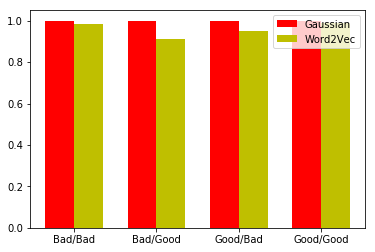

In [20]:
sentiment = {0 : train[train["sentiment"] == 0], 1 : train[train["sentiment"] == 1]}
multivariate_same = []
multivariate_diff = []
word2vec_same = []
word2vec_diff = []
for samples in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    multivariate_dist_same = []
    word2vec_dist_same = []
    multivariate_dist_diff = []
    word2vec_dist_diff = []
    samples1, samples2 = samples
    same = trainDataVecs[sentiment[samples1].sample(n = 120).index]
    centers = same[:20]
    same = same[20:]
    other = trainDataVecs[sentiment[samples2].sample(n = 100).index]
    for center in centers:
        x1 = multivariate_normal.pdf(same, center, sigma_x * np.identity(len(center)))
        x2 = np.dot(same, center) / (np.linalg.norm(same) * np.linalg.norm(center))
        x3 = multivariate_normal.pdf(other, center, sigma_x * np.identity(len(center)))
        x4 = np.dot(other, center) / (np.linalg.norm(other) * np.linalg.norm(center))
        
        multivariate_dist_same.append(x1.mean())
        word2vec_dist_same.append(x2.mean())
        multivariate_dist_diff.append(x3.mean())
        word2vec_dist_diff.append(x4.mean())
        
    multivariate_same.append(sum(multivariate_dist_same) / 20)
    word2vec_same.append(sum(word2vec_dist_same) / 20)
    multivariate_diff.append(sum(multivariate_dist_diff) / 20)
    word2vec_diff.append(sum(word2vec_dist_diff) / 20)

multivariate_same, multivariate_diff, word2vec_same, word2vec_diff = \
np.array(multivariate_same), np.array(multivariate_diff), np.array(word2vec_same), np.array(word2vec_diff)

ind = np.arange(4)
width = 0.35
rects1 = plt.bar(ind, multivariate_diff / multivariate_same, width, color = 'r')
rects2 = plt.bar(ind + width, word2vec_diff / word2vec_same, width, color = 'y')
plt.xticks(ind + width / 2, ('Bad/Bad', 'Bad/Good', 'Good/Bad', 'Good/Good'))
plt.legend((rects1[0], rects2[0]), ('Gaussian', 'Word2Vec'))
plt.show()